In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils.helper import plot_figures
from SourceCodeDataset import SourceCodeDataset
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from Net import Net
from tqdm import tqdm

%matplotlib inline
plt.style.use('seaborn')

In [2]:
transform = transforms.Compose([
        transforms.Resize(228),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root="dataset/", transform=transform)

dataset

Dataset ImageFolder
    Number of datapoints: 189435
    Root location: dataset/
    StandardTransform
Transform: Compose(
               Resize(size=228, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

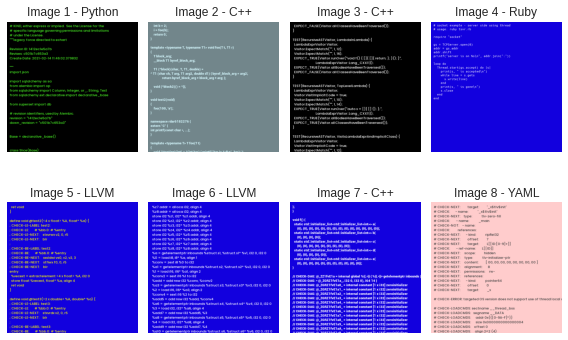

In [3]:
idxs = np.random.randint(0, high=len(dataset)-1, size=8)

vis_dataset = datasets.ImageFolder(root="dataset/")

images_sample = { "Image " + str(counter + 1) + " - " + vis_dataset.classes[vis_dataset[idx][1]]: vis_dataset[idx][0] for counter, idx in enumerate(idxs) }

plot_figures(images_sample, 2, 4)

plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data_size = 0.7
batch_size = 32
num_of_epochs = 150
print("Model load on {}".format(device))

Model load on cuda


In [5]:
from collections import Counter
from sklearn.model_selection import train_test_split

def dataset_to_dict(dataset, data):
    classes = [dataset.targets[i] for i in data.indices]
    val_dict = {dataset.classes[idx]:value for idx,value in Counter(classes).items()}
    val_dict["Total"] = len(data)
    return val_dict

train_size = int(training_data_size * len(dataset))
validation_size = int(len(dataset) * 0.15)
test_size = len(dataset) - train_size - validation_size

train_data, val_data, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=0, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=True)

df = pd.DataFrame([
    dataset_to_dict(dataset, train_data), 
    dataset_to_dict(dataset, val_data), 
    dataset_to_dict(dataset, test_dataset), 
], index=['Train set', 'Validation set', 'Test set'])
col_name="Total"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)

if df.isnull().sum().sum() != 0:
    print("Try to rerun, an error occured!")

df

,Total,C++,Ruby,Common Lisp,YAML,Haskell,Go,PHP,XML,CMake,Python,LLVM,Java,JSON
Train set,132604,12599,12564,12481,10228,9790,12555,12690,6477,2856,12515,12543,12635,2671
Validation set,28415,2796,2702,2664,2030,2135,2711,2648,1383,634,2736,2697,2697,582
Test set,28416,2605,2734,2663,2202,2088,2734,2662,1386,584,2749,2760,2668,581


In [6]:
model = Net(len(dataset.classes))
model.summary()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
from sklearn.utils import class_weight

y = dataset.targets
class_weights=class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(y), 
    y = np.array(y)
)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
class_weights

tensor([0.8096, 3.5768, 0.8183, 0.8096, 1.0399, 3.8007, 0.8096, 0.8096, 0.8096,
        0.8096, 0.8096, 1.5760, 1.0077], device='cuda:0')

In [8]:
criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)


model = model.to(device)

In [9]:
### Testing function
### Controllare che la somma sia corretta
def test_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        acc_test = []
        for image_batch, labels in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            labels = labels.to(device)
            # Encode data
            predicts = model(image_batch) 
            _, predictions = torch.max(predicts.data, 1)
            correct = (predictions == labels).sum().item()
            accuracy = correct / batch_size
            acc_test.append(accuracy)
            conc_out.append(predicts.cpu())
            conc_label.append(labels.cpu())
        # Evaluate global loss
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out.to(device), conc_label.to(device))
    return val_loss.cpu().data, np.array(acc_test).mean()

In [10]:
accuracy_ls = []
loss_ls = []
accuracy_val_ls = []
loss_val_ls = []
max_acc = { "training": 0.0, "validation":0.0 }
for epoch in range(num_of_epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    average_acc = []
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, data in enumerate(tepoch, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            tepoch.set_description(f"Epoch {epoch + 1}/{num_of_epochs}")

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += outputs.shape[0] * loss.item()

            _, predictions = torch.max(outputs.data, 1)
            correct = (predictions == labels).sum().item()
            accuracy = correct / outputs.shape[0]
            average_acc.append(accuracy)
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)
        
        loss_ls.append(epoch_loss / len(train_data))
        accuracy_ls.append(np.array(average_acc).mean())
        print("Loss training: {:.4f} \t Accuracy training: {:.4f}".format(loss_ls[epoch], 100. * accuracy_ls[epoch]))
        loss_val, acc_val = test_epoch(model, device, val_loader, criterion)
        print("Loss validation: {:.4f} \t Accuracy validation: {:.4f}".format(loss_val, 100 * acc_val))
        accuracy_val_ls.append(acc_val)
        loss_val_ls.append(loss_val)
        
    if max_acc["validation"] < acc_val:
        torch.save(model.state_dict(), 'model_weights.pth')
        max_acc["training"] = np.array(average_acc).mean()
        max_acc["validation"] =  acc_val

Epoch 1/150: 100%|█| 4144/4144 [10:26<00:00,  6.62batch/s, accuracy=53.6, loss=1


Loss training: 1.7771 	 Accuracy training: 39.9298
Loss validation: 1.4029 	 Accuracy validation: 54.7966


Epoch 2/150: 100%|█| 4144/4144 [10:15<00:00,  6.74batch/s, accuracy=60.7, loss=1


Loss training: 1.1794 	 Accuracy training: 60.2946
Loss validation: 1.1435 	 Accuracy validation: 60.5293


Epoch 3/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=89.3, loss=0


Loss training: 0.9633 	 Accuracy training: 67.5537
Loss validation: 0.8771 	 Accuracy validation: 69.9535


Epoch 4/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=67.9, loss=0


Loss training: 0.8439 	 Accuracy training: 71.2564
Loss validation: 0.7855 	 Accuracy validation: 72.8005


Epoch 5/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=60.7, loss=0


Loss training: 0.7540 	 Accuracy training: 74.1444
Loss validation: 0.7175 	 Accuracy validation: 76.0311


Epoch 6/150: 100%|█| 4144/4144 [10:25<00:00,  6.62batch/s, accuracy=82.1, loss=0


Loss training: 0.6879 	 Accuracy training: 76.5687
Loss validation: 0.6589 	 Accuracy validation: 77.4951


Epoch 7/150: 100%|█| 4144/4144 [10:10<00:00,  6.78batch/s, accuracy=82.1, loss=0


Loss training: 0.6375 	 Accuracy training: 78.1411
Loss validation: 0.6410 	 Accuracy validation: 78.4769


Epoch 8/150: 100%|█| 4144/4144 [10:10<00:00,  6.78batch/s, accuracy=85.7, loss=0


Loss training: 0.5983 	 Accuracy training: 79.4179
Loss validation: 0.6662 	 Accuracy validation: 77.2945


Epoch 9/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=75, loss=0.7


Loss training: 0.5630 	 Accuracy training: 80.5924
Loss validation: 0.5794 	 Accuracy validation: 80.1274


Epoch 10/150: 100%|█| 4144/4144 [10:10<00:00,  6.79batch/s, accuracy=85.7, loss=


Loss training: 0.5286 	 Accuracy training: 81.6681
Loss validation: 0.5622 	 Accuracy validation: 80.7960


Epoch 11/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=85.7, loss=


Loss training: 0.5026 	 Accuracy training: 82.4335
Loss validation: 0.5355 	 Accuracy validation: 81.4682


Epoch 12/150: 100%|█| 4144/4144 [10:32<00:00,  6.55batch/s, accuracy=89.3, loss=


Loss training: 0.4861 	 Accuracy training: 83.0746
Loss validation: 0.5042 	 Accuracy validation: 83.1327


Epoch 13/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=85.7, loss=


Loss training: 0.4620 	 Accuracy training: 83.8859
Loss validation: 0.5445 	 Accuracy validation: 81.9820


Epoch 14/150: 100%|█| 4144/4144 [10:16<00:00,  6.73batch/s, accuracy=89.3, loss=


Loss training: 0.4449 	 Accuracy training: 84.3181
Loss validation: 0.4370 	 Accuracy validation: 84.8466


Epoch 15/150: 100%|█| 4144/4144 [10:14<00:00,  6.75batch/s, accuracy=78.6, loss=


Loss training: 0.4342 	 Accuracy training: 84.8404
Loss validation: 0.4869 	 Accuracy validation: 83.9070


Epoch 16/150: 100%|█| 4144/4144 [10:11<00:00,  6.77batch/s, accuracy=82.1, loss=


Loss training: 0.4177 	 Accuracy training: 85.2590
Loss validation: 0.4420 	 Accuracy validation: 85.4941


Epoch 17/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=89.3, loss=


Loss training: 0.4049 	 Accuracy training: 85.7886
Loss validation: 0.4512 	 Accuracy validation: 84.8114


Epoch 18/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=89.3, loss=


Loss training: 0.3952 	 Accuracy training: 86.2290
Loss validation: 0.4324 	 Accuracy validation: 84.6319


Epoch 19/150: 100%|█| 4144/4144 [10:25<00:00,  6.62batch/s, accuracy=89.3, loss=


Loss training: 0.3826 	 Accuracy training: 86.5224
Loss validation: 0.4384 	 Accuracy validation: 85.0225


Epoch 20/150: 100%|█| 4144/4144 [10:15<00:00,  6.73batch/s, accuracy=96.4, loss=


Loss training: 0.3736 	 Accuracy training: 86.8762
Loss validation: 0.4078 	 Accuracy validation: 86.0607


Epoch 21/150: 100%|█| 4144/4144 [10:10<00:00,  6.79batch/s, accuracy=82.1, loss=


Loss training: 0.3672 	 Accuracy training: 87.0591
Loss validation: 0.4282 	 Accuracy validation: 85.2407


Epoch 22/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=92.9, loss=


Loss training: 0.3614 	 Accuracy training: 87.1914
Loss validation: 0.4280 	 Accuracy validation: 85.3252


Epoch 23/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=82.1, loss=


Loss training: 0.3533 	 Accuracy training: 87.5017
Loss validation: 0.3951 	 Accuracy validation: 86.3070


Epoch 24/150: 100%|█| 4144/4144 [10:15<00:00,  6.74batch/s, accuracy=96.4, loss=


Loss training: 0.3442 	 Accuracy training: 87.8151
Loss validation: 0.4859 	 Accuracy validation: 83.6184


Epoch 25/150: 100%|█| 4144/4144 [10:10<00:00,  6.78batch/s, accuracy=82.1, loss=


Loss training: 0.3401 	 Accuracy training: 88.0040
Loss validation: 0.4012 	 Accuracy validation: 86.5745


Epoch 26/150: 100%|█| 4144/4144 [10:10<00:00,  6.78batch/s, accuracy=92.9, loss=


Loss training: 0.3344 	 Accuracy training: 88.1649
Loss validation: 0.4191 	 Accuracy validation: 85.2689


Epoch 27/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=82.1, loss=


Loss training: 0.3251 	 Accuracy training: 88.4089
Loss validation: 0.3972 	 Accuracy validation: 86.0783


Epoch 28/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss=


Loss training: 0.3207 	 Accuracy training: 88.6157
Loss validation: 0.3647 	 Accuracy validation: 87.3944


Epoch 29/150: 100%|█| 4144/4144 [10:17<00:00,  6.72batch/s, accuracy=92.9, loss=


Loss training: 0.3162 	 Accuracy training: 88.7810
Loss validation: 0.4032 	 Accuracy validation: 85.5785


Epoch 30/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=85.7, loss=


Loss training: 0.3127 	 Accuracy training: 88.8871
Loss validation: 0.3954 	 Accuracy validation: 86.6589


Epoch 31/150: 100%|█| 4144/4144 [10:10<00:00,  6.79batch/s, accuracy=92.9, loss=


Loss training: 0.3055 	 Accuracy training: 89.1332
Loss validation: 0.4016 	 Accuracy validation: 85.9621


Epoch 32/150: 100%|█| 4144/4144 [10:10<00:00,  6.78batch/s, accuracy=89.3, loss=


Loss training: 0.3002 	 Accuracy training: 89.4505
Loss validation: 0.3777 	 Accuracy validation: 87.6513


Epoch 33/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss=


Loss training: 0.2963 	 Accuracy training: 89.4905
Loss validation: 0.3541 	 Accuracy validation: 87.9716


Epoch 34/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=85.7, loss=


Loss training: 0.2933 	 Accuracy training: 89.4844
Loss validation: 0.4692 	 Accuracy validation: 83.0694


Epoch 35/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=85.7, loss=


Loss training: 0.2878 	 Accuracy training: 89.7543
Loss validation: 0.3935 	 Accuracy validation: 86.9721


Epoch 36/150: 100%|█| 4144/4144 [10:41<00:00,  6.46batch/s, accuracy=92.9, loss=


Loss training: 0.2856 	 Accuracy training: 89.8051
Loss validation: 0.4103 	 Accuracy validation: 86.0677


Epoch 37/150: 100%|█| 4144/4144 [11:15<00:00,  6.14batch/s, accuracy=89.3, loss=


Loss training: 0.2820 	 Accuracy training: 89.9995
Loss validation: 0.3493 	 Accuracy validation: 88.0983


Epoch 38/150: 100%|█| 4144/4144 [11:21<00:00,  6.08batch/s, accuracy=85.7, loss=


Loss training: 0.2792 	 Accuracy training: 90.0741
Loss validation: 0.4007 	 Accuracy validation: 86.9264


Epoch 39/150: 100%|█| 4144/4144 [10:17<00:00,  6.71batch/s, accuracy=85.7, loss=


Loss training: 0.2738 	 Accuracy training: 90.2573
Loss validation: 0.3754 	 Accuracy validation: 87.0812


Epoch 40/150: 100%|█| 4144/4144 [10:17<00:00,  6.71batch/s, accuracy=82.1, loss=


Loss training: 0.2697 	 Accuracy training: 90.2874
Loss validation: 0.3447 	 Accuracy validation: 87.8836


Epoch 41/150: 100%|█| 4144/4144 [10:14<00:00,  6.75batch/s, accuracy=92.9, loss=


Loss training: 0.2672 	 Accuracy training: 90.4936
Loss validation: 0.3618 	 Accuracy validation: 87.5141


Epoch 42/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=92.9, loss=


Loss training: 0.2641 	 Accuracy training: 90.5637
Loss validation: 0.3805 	 Accuracy validation: 86.7962


Epoch 43/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=85.7, loss=


Loss training: 0.2587 	 Accuracy training: 90.7686
Loss validation: 0.3567 	 Accuracy validation: 87.9892


Epoch 44/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=85.7, loss=


Loss training: 0.2599 	 Accuracy training: 90.6736
Loss validation: 0.3569 	 Accuracy validation: 88.1334


Epoch 45/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=89.3, loss=


Loss training: 0.2550 	 Accuracy training: 90.8223
Loss validation: 0.3622 	 Accuracy validation: 87.5352


Epoch 46/150: 100%|█| 4144/4144 [10:15<00:00,  6.73batch/s, accuracy=89.3, loss=


Loss training: 0.2459 	 Accuracy training: 91.0990
Loss validation: 0.3397 	 Accuracy validation: 88.5980


Epoch 47/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=75, loss=0.


Loss training: 0.2551 	 Accuracy training: 90.9244
Loss validation: 0.3928 	 Accuracy validation: 86.5534


Epoch 48/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=85.7, loss=


Loss training: 0.2449 	 Accuracy training: 91.1954
Loss validation: 0.3700 	 Accuracy validation: 87.7569


Epoch 49/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=85.7, loss=


Loss training: 0.2461 	 Accuracy training: 91.1894
Loss validation: 0.3506 	 Accuracy validation: 88.1862


Epoch 50/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=89.3, loss=


Loss training: 0.2412 	 Accuracy training: 91.3833
Loss validation: 0.3576 	 Accuracy validation: 87.5704


Epoch 51/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=100, loss=0


Loss training: 0.2401 	 Accuracy training: 91.3814
Loss validation: 0.3386 	 Accuracy validation: 88.4079


Epoch 52/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=89.3, loss=


Loss training: 0.2363 	 Accuracy training: 91.5266
Loss validation: 0.3188 	 Accuracy validation: 89.0273


Epoch 53/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=85.7, loss=


Loss training: 0.2334 	 Accuracy training: 91.6245
Loss validation: 0.3243 	 Accuracy validation: 89.2772


Epoch 54/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=92.9, loss=


Loss training: 0.2323 	 Accuracy training: 91.7160
Loss validation: 0.3821 	 Accuracy validation: 87.3276


Epoch 55/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=85.7, loss=


Loss training: 0.2358 	 Accuracy training: 91.5453
Loss validation: 0.3467 	 Accuracy validation: 88.7071


Epoch 56/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=92.9, loss=


Loss training: 0.2285 	 Accuracy training: 91.7703
Loss validation: 0.3250 	 Accuracy validation: 89.2349


Epoch 57/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss=


Loss training: 0.2236 	 Accuracy training: 91.9715
Loss validation: 0.3320 	 Accuracy validation: 89.3229


Epoch 58/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=96.4, loss=


Loss training: 0.2256 	 Accuracy training: 91.8488
Loss validation: 0.3626 	 Accuracy validation: 88.3622


Epoch 59/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=92.9, loss=


Loss training: 0.2196 	 Accuracy training: 92.1051
Loss validation: 0.3401 	 Accuracy validation: 88.2496


Epoch 60/150: 100%|█| 4144/4144 [11:19<00:00,  6.10batch/s, accuracy=92.9, loss=


Loss training: 0.2228 	 Accuracy training: 91.9844
Loss validation: 0.3554 	 Accuracy validation: 88.1194


Epoch 61/150: 100%|█| 4144/4144 [11:18<00:00,  6.11batch/s, accuracy=82.1, loss=


Loss training: 0.2151 	 Accuracy training: 92.2797
Loss validation: 0.3329 	 Accuracy validation: 88.8408


Epoch 62/150: 100%|█| 4144/4144 [10:48<00:00,  6.39batch/s, accuracy=82.1, loss=


Loss training: 0.2135 	 Accuracy training: 92.2933
Loss validation: 0.3223 	 Accuracy validation: 89.2912


Epoch 63/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=96.4, loss=


Loss training: 0.2116 	 Accuracy training: 92.3450
Loss validation: 0.3405 	 Accuracy validation: 89.1646


Epoch 64/150: 100%|█| 4144/4144 [10:15<00:00,  6.74batch/s, accuracy=92.9, loss=


Loss training: 0.2093 	 Accuracy training: 92.3306
Loss validation: 0.3257 	 Accuracy validation: 89.2244


Epoch 65/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=92.9, loss=


Loss training: 0.2084 	 Accuracy training: 92.5153
Loss validation: 0.3174 	 Accuracy validation: 89.1153


Epoch 66/150: 100%|█| 4144/4144 [10:15<00:00,  6.73batch/s, accuracy=85.7, loss=


Loss training: 0.2112 	 Accuracy training: 92.3251
Loss validation: 0.3506 	 Accuracy validation: 88.3235


Epoch 67/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=100, loss=0


Loss training: 0.2034 	 Accuracy training: 92.7274
Loss validation: 0.3072 	 Accuracy validation: 89.8262


Epoch 68/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=96.4, loss=


Loss training: 0.2033 	 Accuracy training: 92.6821
Loss validation: 0.3505 	 Accuracy validation: 88.4924


Epoch 69/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=96.4, loss=


Loss training: 0.2023 	 Accuracy training: 92.6708
Loss validation: 0.3265 	 Accuracy validation: 89.3757


Epoch 70/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=92.9, loss=


Loss training: 0.2042 	 Accuracy training: 92.6925
Loss validation: 0.3228 	 Accuracy validation: 88.8267


Epoch 71/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=92.9, loss=


Loss training: 0.1993 	 Accuracy training: 92.8449
Loss validation: 0.3828 	 Accuracy validation: 87.0601


Epoch 72/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=92.9, loss=


Loss training: 0.1980 	 Accuracy training: 92.8863
Loss validation: 0.3250 	 Accuracy validation: 89.3159


Epoch 73/150: 100%|█| 4144/4144 [10:15<00:00,  6.73batch/s, accuracy=100, loss=0


Loss training: 0.1982 	 Accuracy training: 92.8971
Loss validation: 0.3401 	 Accuracy validation: 89.1470


Epoch 74/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=85.7, loss=


Loss training: 0.1980 	 Accuracy training: 92.8688
Loss validation: 0.3450 	 Accuracy validation: 88.8760


Epoch 75/150: 100%|█| 4144/4144 [10:30<00:00,  6.57batch/s, accuracy=96.4, loss=


Loss training: 0.1972 	 Accuracy training: 92.8638
Loss validation: 0.3446 	 Accuracy validation: 88.3200


Epoch 76/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=92.9, loss=


Loss training: 0.1934 	 Accuracy training: 93.0432
Loss validation: 0.3388 	 Accuracy validation: 88.5100


Epoch 77/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss=


Loss training: 0.1931 	 Accuracy training: 93.0138
Loss validation: 0.3346 	 Accuracy validation: 88.5311


Epoch 78/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=92.9, loss=


Loss training: 0.1897 	 Accuracy training: 93.2076
Loss validation: 0.3215 	 Accuracy validation: 89.5411


Epoch 79/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=92.9, loss=


Loss training: 0.1870 	 Accuracy training: 93.2310
Loss validation: 0.3361 	 Accuracy validation: 89.0203


Epoch 80/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=92.9, loss=


Loss training: 0.1871 	 Accuracy training: 93.2355
Loss validation: 0.3148 	 Accuracy validation: 89.7100


Epoch 81/150: 100%|█| 4144/4144 [10:15<00:00,  6.73batch/s, accuracy=89.3, loss=


Loss training: 0.1898 	 Accuracy training: 93.1660
Loss validation: 0.3691 	 Accuracy validation: 88.3270


Epoch 82/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=89.3, loss=


Loss training: 0.1835 	 Accuracy training: 93.3447
Loss validation: 0.3415 	 Accuracy validation: 88.2531


Epoch 83/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=89.3, loss=


Loss training: 0.1829 	 Accuracy training: 93.3221
Loss validation: 0.3251 	 Accuracy validation: 89.2420


Epoch 84/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=89.3, loss=


Loss training: 0.1831 	 Accuracy training: 93.4782
Loss validation: 0.3181 	 Accuracy validation: 89.4672


Epoch 85/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=96.4, loss=


Loss training: 0.1807 	 Accuracy training: 93.4784
Loss validation: 0.3705 	 Accuracy validation: 87.7851


Epoch 86/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=100, loss=0


Loss training: 0.1805 	 Accuracy training: 93.4755
Loss validation: 0.3434 	 Accuracy validation: 88.9041


Epoch 87/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=92.9, loss=


Loss training: 0.1788 	 Accuracy training: 93.5839
Loss validation: 0.3683 	 Accuracy validation: 88.6402


Epoch 88/150: 100%|█| 4144/4144 [10:14<00:00,  6.75batch/s, accuracy=82.1, loss=


Loss training: 0.1810 	 Accuracy training: 93.5459
Loss validation: 0.3314 	 Accuracy validation: 89.7804


Epoch 89/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=96.4, loss=


Loss training: 0.1796 	 Accuracy training: 93.4663
Loss validation: 0.3046 	 Accuracy validation: 89.6678


Epoch 90/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss=


Loss training: 0.1771 	 Accuracy training: 93.5944
Loss validation: 0.3515 	 Accuracy validation: 88.4466


Epoch 91/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=96.4, loss=


Loss training: 0.1749 	 Accuracy training: 93.5734
Loss validation: 0.3127 	 Accuracy validation: 89.3511


Epoch 92/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=78.6, loss=


Loss training: 0.1719 	 Accuracy training: 93.7056
Loss validation: 0.3051 	 Accuracy validation: 89.6748


Epoch 93/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=89.3, loss=


Loss training: 0.1809 	 Accuracy training: 93.4835
Loss validation: 0.3321 	 Accuracy validation: 89.0590


Epoch 94/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=85.7, loss=


Loss training: 0.1746 	 Accuracy training: 93.7028
Loss validation: 0.3143 	 Accuracy validation: 89.6185


Epoch 95/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss=


Loss training: 0.1736 	 Accuracy training: 93.7581
Loss validation: 0.3299 	 Accuracy validation: 89.0731


Epoch 96/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss=


Loss training: 0.1733 	 Accuracy training: 93.7783
Loss validation: 0.3375 	 Accuracy validation: 88.7950


Epoch 97/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=89.3, loss=


Loss training: 0.1712 	 Accuracy training: 93.8025
Loss validation: 0.3093 	 Accuracy validation: 90.0514


Epoch 98/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=100, loss=0


Loss training: 0.1699 	 Accuracy training: 93.9197
Loss validation: 0.3457 	 Accuracy validation: 89.0308


Epoch 99/150: 100%|█| 4144/4144 [10:18<00:00,  6.70batch/s, accuracy=96.4, loss=


Loss training: 0.1660 	 Accuracy training: 93.9377
Loss validation: 0.3261 	 Accuracy validation: 89.6396


Epoch 100/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=96.4, loss


Loss training: 0.1670 	 Accuracy training: 93.9791
Loss validation: 0.3256 	 Accuracy validation: 89.6080


Epoch 101/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=100, loss=


Loss training: 0.1673 	 Accuracy training: 93.9506
Loss validation: 0.3770 	 Accuracy validation: 88.3059


Epoch 102/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=96.4, loss


Loss training: 0.1669 	 Accuracy training: 93.9098
Loss validation: 0.3221 	 Accuracy validation: 89.1540


Epoch 103/150: 100%|█| 4144/4144 [10:17<00:00,  6.71batch/s, accuracy=85.7, loss


Loss training: 0.1630 	 Accuracy training: 94.1244
Loss validation: 0.3778 	 Accuracy validation: 87.6936


Epoch 104/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=92.9, loss


Loss training: 0.1636 	 Accuracy training: 94.0906
Loss validation: 0.3184 	 Accuracy validation: 89.6572


Epoch 105/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=96.4, loss


Loss training: 0.1646 	 Accuracy training: 94.0485
Loss validation: 0.3005 	 Accuracy validation: 90.1957


Epoch 106/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=85.7, loss


Loss training: 0.1644 	 Accuracy training: 94.0256
Loss validation: 0.3296 	 Accuracy validation: 89.7487


Epoch 107/150: 100%|█| 4144/4144 [10:14<00:00,  6.75batch/s, accuracy=100, loss=


Loss training: 0.1637 	 Accuracy training: 94.0147
Loss validation: 0.3160 	 Accuracy validation: 89.7769


Epoch 108/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=100, loss=


Loss training: 0.1631 	 Accuracy training: 94.0637
Loss validation: 0.3285 	 Accuracy validation: 89.6819


Epoch 109/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss


Loss training: 0.1615 	 Accuracy training: 94.1200
Loss validation: 0.3483 	 Accuracy validation: 89.2596


Epoch 110/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=96.4, loss


Loss training: 0.1624 	 Accuracy training: 94.1579
Loss validation: 0.3793 	 Accuracy validation: 87.5880


Epoch 111/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=96.4, loss


Loss training: 0.1589 	 Accuracy training: 94.3388
Loss validation: 0.3114 	 Accuracy validation: 89.4355


Epoch 112/150: 100%|█| 4144/4144 [10:16<00:00,  6.73batch/s, accuracy=89.3, loss


Loss training: 0.1597 	 Accuracy training: 94.1433
Loss validation: 0.3286 	 Accuracy validation: 89.3722


Epoch 113/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=92.9, loss


Loss training: 0.1584 	 Accuracy training: 94.2573
Loss validation: 0.3097 	 Accuracy validation: 90.2520


Epoch 114/150: 100%|█| 4144/4144 [10:15<00:00,  6.74batch/s, accuracy=92.9, loss


Loss training: 0.1562 	 Accuracy training: 94.2920
Loss validation: 0.3453 	 Accuracy validation: 89.4566


Epoch 115/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss


Loss training: 0.1585 	 Accuracy training: 94.2867
Loss validation: 0.3265 	 Accuracy validation: 89.0907


Epoch 116/150: 100%|█| 4144/4144 [10:15<00:00,  6.74batch/s, accuracy=96.4, loss


Loss training: 0.1554 	 Accuracy training: 94.4263
Loss validation: 0.3311 	 Accuracy validation: 89.4496


Epoch 117/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss


Loss training: 0.1505 	 Accuracy training: 94.5453
Loss validation: 0.3682 	 Accuracy validation: 88.2848


Epoch 118/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=96.4, loss


Loss training: 0.1521 	 Accuracy training: 94.4987
Loss validation: 0.3574 	 Accuracy validation: 88.7774


Epoch 119/150: 100%|█| 4144/4144 [10:17<00:00,  6.72batch/s, accuracy=92.9, loss


Loss training: 0.1555 	 Accuracy training: 94.3425
Loss validation: 0.3062 	 Accuracy validation: 89.9810


Epoch 120/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss


Loss training: 0.1539 	 Accuracy training: 94.4721
Loss validation: 0.3042 	 Accuracy validation: 89.8825


Epoch 121/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=100, loss=


Loss training: 0.1544 	 Accuracy training: 94.4468
Loss validation: 0.3100 	 Accuracy validation: 89.7874


Epoch 122/150: 100%|█| 4144/4144 [10:10<00:00,  6.79batch/s, accuracy=92.9, loss


Loss training: 0.1534 	 Accuracy training: 94.4669
Loss validation: 0.3331 	 Accuracy validation: 88.9147


Epoch 123/150: 100%|█| 4144/4144 [10:11<00:00,  6.77batch/s, accuracy=96.4, loss


Loss training: 0.1542 	 Accuracy training: 94.3766
Loss validation: 0.3148 	 Accuracy validation: 89.8719


Epoch 124/150: 100%|█| 4144/4144 [10:18<00:00,  6.70batch/s, accuracy=85.7, loss


Loss training: 0.1558 	 Accuracy training: 94.4268
Loss validation: 0.3161 	 Accuracy validation: 90.1816


Epoch 125/150: 100%|█| 4144/4144 [10:14<00:00,  6.75batch/s, accuracy=96.4, loss


Loss training: 0.1527 	 Accuracy training: 94.5032
Loss validation: 0.3390 	 Accuracy validation: 88.9358


Epoch 126/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=96.4, loss


Loss training: 0.1486 	 Accuracy training: 94.6857
Loss validation: 0.3194 	 Accuracy validation: 89.4707


Epoch 127/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=89.3, loss


Loss training: 0.1515 	 Accuracy training: 94.4917
Loss validation: 0.3198 	 Accuracy validation: 89.7135


Epoch 128/150: 100%|█| 4144/4144 [10:12<00:00,  6.76batch/s, accuracy=89.3, loss


Loss training: 0.1527 	 Accuracy training: 94.5437
Loss validation: 0.3292 	 Accuracy validation: 89.0484


Epoch 129/150: 100%|█| 4144/4144 [10:17<00:00,  6.71batch/s, accuracy=92.9, loss


Loss training: 0.1467 	 Accuracy training: 94.7218
Loss validation: 0.3436 	 Accuracy validation: 89.1294


Epoch 130/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=96.4, loss


Loss training: 0.1482 	 Accuracy training: 94.6880
Loss validation: 0.3449 	 Accuracy validation: 89.0379


Epoch 131/150: 100%|█| 4144/4144 [10:17<00:00,  6.71batch/s, accuracy=85.7, loss


Loss training: 0.1504 	 Accuracy training: 94.5263
Loss validation: 0.3063 	 Accuracy validation: 89.8262


Epoch 132/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss


Loss training: 0.1527 	 Accuracy training: 94.4775
Loss validation: 0.3405 	 Accuracy validation: 88.8971


Epoch 133/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=89.3, loss


Loss training: 0.1519 	 Accuracy training: 94.5211
Loss validation: 0.3295 	 Accuracy validation: 89.2103


Epoch 134/150: 100%|█| 4144/4144 [10:11<00:00,  6.77batch/s, accuracy=96.4, loss


Loss training: 0.1487 	 Accuracy training: 94.6782
Loss validation: 0.3514 	 Accuracy validation: 88.5839


Epoch 135/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=92.9, loss


Loss training: 0.1553 	 Accuracy training: 94.3832
Loss validation: 0.3255 	 Accuracy validation: 89.2244


Epoch 136/150: 100%|█| 4144/4144 [10:16<00:00,  6.72batch/s, accuracy=96.4, loss


Loss training: 0.1490 	 Accuracy training: 94.7430
Loss validation: 0.3269 	 Accuracy validation: 89.7734


Epoch 137/150: 100%|█| 4144/4144 [10:34<00:00,  6.53batch/s, accuracy=92.9, loss


Loss training: 0.1434 	 Accuracy training: 94.8312
Loss validation: 0.3504 	 Accuracy validation: 88.3270


Epoch 138/150: 100%|█| 4144/4144 [10:15<00:00,  6.73batch/s, accuracy=85.7, loss


Loss training: 0.1434 	 Accuracy training: 94.8279
Loss validation: 0.3353 	 Accuracy validation: 88.9640


Epoch 139/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=89.3, loss


Loss training: 0.1425 	 Accuracy training: 94.8914
Loss validation: 0.3479 	 Accuracy validation: 88.5698


Epoch 140/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=96.4, loss


Loss training: 0.1452 	 Accuracy training: 94.7468
Loss validation: 0.3137 	 Accuracy validation: 89.5904


Epoch 141/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=100, loss=


Loss training: 0.1414 	 Accuracy training: 94.9226
Loss validation: 0.3143 	 Accuracy validation: 89.6150


Epoch 142/150: 100%|█| 4144/4144 [10:11<00:00,  6.77batch/s, accuracy=100, loss=


Loss training: 0.1418 	 Accuracy training: 94.8231
Loss validation: 0.3406 	 Accuracy validation: 88.6367


Epoch 143/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=92.9, loss


Loss training: 0.1408 	 Accuracy training: 94.8885
Loss validation: 0.3050 	 Accuracy validation: 90.2273


Epoch 144/150: 100%|█| 4144/4144 [10:13<00:00,  6.76batch/s, accuracy=96.4, loss


Loss training: 0.1416 	 Accuracy training: 94.9029
Loss validation: 0.3113 	 Accuracy validation: 90.3259


Epoch 145/150: 100%|█| 4144/4144 [10:11<00:00,  6.78batch/s, accuracy=100, loss=


Loss training: 0.1439 	 Accuracy training: 94.8427
Loss validation: 0.3233 	 Accuracy validation: 89.3440


Epoch 146/150: 100%|█| 4144/4144 [10:14<00:00,  6.75batch/s, accuracy=100, loss=


Loss training: 0.1424 	 Accuracy training: 94.8065
Loss validation: 0.3068 	 Accuracy validation: 90.2273


Epoch 147/150: 100%|█| 4144/4144 [10:14<00:00,  6.74batch/s, accuracy=100, loss=


Loss training: 0.1429 	 Accuracy training: 94.8827
Loss validation: 0.3209 	 Accuracy validation: 89.5728


Epoch 148/150: 100%|█| 4144/4144 [10:13<00:00,  6.75batch/s, accuracy=92.9, loss


Loss training: 0.1387 	 Accuracy training: 94.9684
Loss validation: 0.3109 	 Accuracy validation: 90.0901


Epoch 149/150: 100%|█| 4144/4144 [10:12<00:00,  6.77batch/s, accuracy=100, loss=


Loss training: 0.1395 	 Accuracy training: 94.9716
Loss validation: 0.3251 	 Accuracy validation: 88.9886


Epoch 150/150: 100%|█| 4144/4144 [10:15<00:00,  6.74batch/s, accuracy=96.4, loss


Loss training: 0.1425 	 Accuracy training: 94.8637
Loss validation: 0.3199 	 Accuracy validation: 90.1921


In [18]:
for k,v in max_acc.items():
    print("Accuracy on {} set: {:.2f}%".format(k, v * 100))

Accuracy on training set: 94.90%
Accuracy on validation set: 90.33%


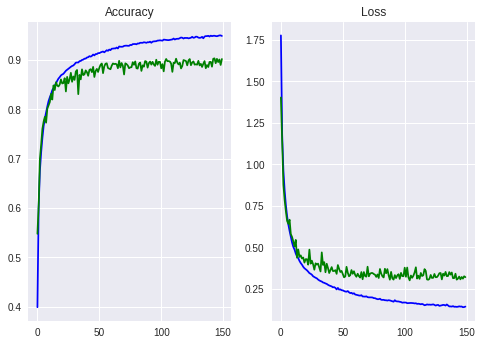

In [13]:
ax1 = plt.subplot(1, 2, 1)
plt.plot(accuracy_ls, 'b-', label="Training")
plt.plot(accuracy_val_ls, 'g-', label="Validation")
ax1.set_title('Accuracy')

ax2 = plt.subplot(1, 2, 2)
plt.plot(loss_ls, 'b-', label="Training")
plt.plot(loss_val_ls, 'g-', label="Validation")
ax2.set_title('Loss')

plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

model = Net(len(dataset.classes))
model.load_state_dict(torch.load('model_weights.pth'))
model.to(device)
model.eval()

correct = 0
total = 0
labels_ls = []
output_ls = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        labels_ls.append(labels.item())
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        output_ls.append(predicted.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

Accuracy on test set: 90.43%


<module 'matplotlib.pyplot' from '/home/pennino/miniconda3/envs/issc/lib/python3.9/site-packages/matplotlib/pyplot.py'>

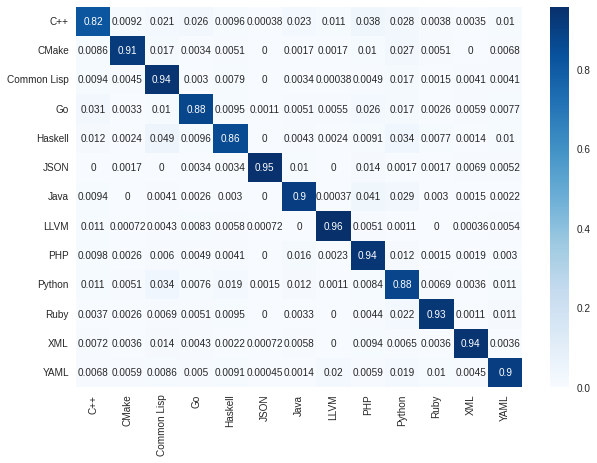

In [16]:
print("Accuracy on test set: {:.2f}%".format((correct / total) * 100))
#classes = [dataset.targets[i] for i in dataset.indices]
#labels_ls = list(map(dataset.get_class, labels_ls))
#output_ls = list(map(dataset.get_class, output_ls))
revers_cti = [k for k, v in dataset.class_to_idx.items()]
new_labels_ls = [ revers_cti[label] for label in labels_ls]
new_output_ls = [ revers_cti[label] for label in output_ls]
array = confusion_matrix(new_labels_ls, new_output_ls, normalize='true', labels=revers_cti)
df_cm = pd.DataFrame(array, index =revers_cti,
              columns =revers_cti)
plt.figure(figsize = (10,7))
s = sn.heatmap(df_cm, annot=True, cmap="Blues") # 
plt.yticks(rotation=0)
plt